# Using 100 SKIRT Runs Instead of 6

We have data for 100 SKIRT runs: more than 15 times the data we had initially.

The aim here is to observe the effect of having more data on the model's performance.

This time, I'm going to make sure that all inclinations for a given run are either in the test or train set, and not both, since they correspond to measurements of the same galaxy. We want the model to predict values for a galaxy at every inclination we want; having parts of a run in both sets, therefore, defeats our purpose.

In [611]:
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import TensorDataset, DataLoader

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The Model

In [612]:
class TripleOutputBNN(nn.Module):
    """
    This is a class for a Bayesian Neural Network with 3 outputs.
    Attributes:
        no_of_neurones (int): number of neurones in the hidden layer.
        dropout_prob (float): dropout probability.
    """

    def __init__(self, no_of_neurones, dropout_prob):
        """
        The constructor for TripleOutputBNN class.
        
        Parameters:
            no_of_neurones (int): number of neurones in the hidden layer.
            dropout_prob (float): dropout probability.
        """
        
        super(TripleOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_y0 = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y1 = nn.Sequential( #this is the output layer for y1
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y2 = nn.Sequential( #this is the output layer for y2
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        """
        This function performs the forward pass.
        Parameters:
            x (tensor): input tensor.
        
        Returns:
            y0 (tensor): output tensor for y0.
            y1 (tensor): output tensor for y1.
            y2 (tensor): output tensor for y2.
        """

        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        y2 = self.output_layer_y2(shared)
        return y0, y1, y2

## Initialising the Model

In [613]:
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = TripleOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer

## Training the Model

In [614]:
def train_model(model_attributes, input_train, output_train, epochs: int, batch_size: int):
    """
    Train the model using batch training.

    Parameters:
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_train (tensor): Input tensor for training.
    - output_train (tensor): Output tensor for training.
    - epochs (int): Number of epochs to train the model.
    - batch_size (int): Batch size for training.

    Returns:
    - The trained model.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    model = model.train()

    # Create a TensorDataset from input and output tensors
    tensor_dataset = TensorDataset(input_train, output_train)

    # Create a DataLoader for batch training
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        for batch_data, batch_labels in data_loader:
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            n_pred, f_pred, r_pred = model(batch_data)

            # Calculate MSE loss for each output and KL divergence
            n_mse = mse_loss(n_pred, batch_labels[:, 0])
            f_mse = mse_loss(f_pred, batch_labels[:, 1])
            r_mse = mse_loss(r_pred, batch_labels[:, 2])
            kl = kl_loss(model)

            # Calculate cost (MSE + KL)
            n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
            cost = n_cost + f_cost + r_cost

            # Backpropagation and optimization
            cost.backward()
            # n_cost.backward(retain_graph=True)
            # f_cost.backward(retain_graph=True)
            # r_cost.backward()
            optimizer.step()

        # Optionally, print the cost at the end of each epoch or save checkpoints
        print(f"- Epoch {epoch + 1}: n cost: {n_cost.item():.3f}, f cost: {f_cost.item():.3f}, r cost: {r_cost.item():.3f}")

    return model

## Testing the Model

In [615]:
def test_model(model, model_attributes, input_test, output_test):
    """
    Test the model.

    Parameters:
    - model (nn.Module): Trained model.
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_test (tensor): Input tensor for testing.
    - output_test (tensor): Output tensor for testing.

    Returns:
    - mean_n_results (tensor): Mean of the predictions for y0.
    - std_n_results (tensor): Standard deviation of the predictions for y0.
    - mean_f_results (tensor): Mean of the predictions for y1.
    - std_f_results (tensor): Standard deviation of the predictions for y1.
    - mean_r_results (tensor): Mean of the predictions for y2.
    - std_r_results (tensor): Standard deviation of the predictions for y2.
    """

    mse_loss, kl_loss, kl_weight, optimizer = model_attributes[1:]

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model = model.eval().cpu()
    input_test = input_test.cpu()
    output_test = output_test.cpu()

    n_pred = np.array([model(input_test)[0].detach().numpy() for _ in range(500)]).T
    f_pred = np.array([model(input_test)[1].detach().numpy() for _ in range(500)]).T
    r_pred = np.array([model(input_test)[2].detach().numpy() for _ in range(500)]).T

    print(n_pred.shape)

    #for each prediction of row, find mean and standard deviation
    mean_n_results = np.mean(n_pred, axis = 2)
    std_n_results = np.std(n_pred, axis = 2)
    mean_f_results = np.mean(f_pred, axis = 2)
    std_f_results = np.std(f_pred, axis = 2)
    mean_r_results = np.mean(r_pred, axis = 2)
    std_r_results = np.std(r_pred, axis = 2)

    print(mean_n_results.shape)

    #find the cost of the model
    n_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_n_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,0].T), dim=2))
    f_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_f_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,1].T), dim=2))
    r_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_r_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,2].T), dim=2))

    kl = kl_loss(model)
    n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
    # cost = n_cost + f_cost + r_cost

    print(f"- n cost: {n_cost.item():.3f}, f cost: {f_cost.item():.3f}, r cost: {r_cost.item():.3f}")

    return mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results

# The Data Processing

## Reading Input Parameters from Input File

In [616]:
def read_params(filename: str, filepath: str = '../../data/radiative_transfer/input/'):
    """
    Read the parameters from the input file.

    Parameters:
    - filename (str): Name of the input file.
    - filepath (str): Path to the input file. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - table (dict): Dictionary containing the parameters.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):

        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )

        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table

## Reading Input Files

In [617]:
def read_parameter_files(filenames: list, filepath: str = "../../../data/radiative_transfer/input/"):
    """
    Read the parameter files.

    Parameters:
    - filenames (list): List of filenames.
    - filepath (str): Path to the parameter files. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - list_log_mstar (np.array): Array of log of stellar mass.
    - list_log_mdust_over_mstar (np.array): Array of log of dust mass over stellar mass.
    - list_theta (np.array): Array of viewing angles.
    """

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar

    return list_log_mstar, list_log_mdust_over_mstar, list_theta

## Reading Output Files

In [618]:
def read_h5_file(filename: str, data, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../../data/radiative_transfer/output/'):
    """
    Read the output file.

    Parameters:
    - filename (str): Name of the output file.
    - data (pd.DataFrame): DataFrame containing the data.
    - thetas (list): List of viewing angles.
    - log_mstar (float): log of stellar mass.
    - log_mdust_over_mstar (float): log of dust mass over stellar mass.
    - filepath (str): Path to the output file. Default is '../../data/radiative_transfer/output/'.

    Returns:
    - wvl (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    normalise = lambda x: (x - np.mean(x)) / np.std(x)

    filepath += filename 
    # print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    for i in range(len(hdf_keys)):

        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy(dtype=np.float64) # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy(dtype=np.float64) # flux [W/m^2]
        r = table['r'].to_numpy(dtype=np.float64) # half-light radius [kpc]
        n = table['n'].to_numpy(dtype=np.float64) # Sersic index

        flux, r, n = normalise(flux), normalise(r), normalise(n)

        data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)

    return wvl, data.reset_index(drop=True)

## Compiling the Dataset

In [619]:
def generate_dataset(data, params, files):
    """
    Generate the dataset.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - params (list): List of parameter files.
    - files (list): List of output files.

    Returns:
    - wavelength (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(params)

    for i in range(len(files)):
        wavelength, data = read_h5_file(files[i], data, np.sin(list_theta), list_log_mstar[i], list_log_mdust_over_mstar[i])

    return wavelength, data

# The Results

## Splitting the Train & Test Sets to I/O Pairs

In [620]:
def convert_to_tensor(data):
    """
    Convert the DataFrame to a tensor.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.

    Returns:
    - data (tensor): Tensor containing the data.
    """

    data = data.applymap(np.array)
    stacked_input_arrays = np.stack(data.apply(lambda row: np.stack(row, axis=0), axis=1).to_numpy())
    data = torch.Tensor(stacked_input_arrays).to(device)

    return data

In [621]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [file for file in os.listdir("../../../data/radiative_transfer/input/") if file.startswith("parameters")][:100]
h5_files = [file for file in os.listdir("../../../data/radiative_transfer/output/") if file.startswith("data")][:100]

# splitting the dataset into training and testing sets by filename - this is to ensure every inclination of a run is in the same set
parameter_train, parameter_test, h5_train, h5_test = train_test_split(parameter_files, h5_files, test_size=0.2, random_state=0)

wavelength, h5_train_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_train, h5_train)
wavelength, h5_test_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_test, h5_test)

# save h5_test_data to csv
h5_test_data.to_csv("h5_train_data.csv", index=False)

#split training and testing sets into inputs and outputs
train_inputs, train_outputs = h5_train_data[["log_mstar", "log_mdust_over_mstar", "theta"]], h5_train_data[["n", "flux", "r"]]
test_inputs, test_outputs = h5_test_data[["log_mstar", "log_mdust_over_mstar", "theta"]], h5_test_data[["n", "flux", "r"]]

#convert training and testing data into numpy arrays
train_inputs, test_inputs = train_inputs.to_numpy(), test_inputs.to_numpy()
train_inputs, test_inputs = torch.Tensor(train_inputs).to(device), torch.Tensor(test_inputs).to(device)

train_outputs, test_outputs = convert_to_tensor(train_outputs).to(device), convert_to_tensor(test_outputs).to(device)

## Setting up the Model

In [622]:
#initialise, train, and test the model
model_attributes = initialise_model(1000, 0.3, lr=0.01)
model = train_model(model_attributes, train_inputs, train_outputs, 25, 10)

- Epoch 1: n cost: 1.125, f cost: 0.904, r cost: 0.859
- Epoch 2: n cost: 0.796, f cost: 0.722, r cost: 0.699
- Epoch 3: n cost: 0.652, f cost: 0.583, r cost: 0.517
- Epoch 4: n cost: 0.527, f cost: 0.460, r cost: 0.352
- Epoch 5: n cost: 0.431, f cost: 0.343, r cost: 0.247
- Epoch 6: n cost: 0.360, f cost: 0.253, r cost: 0.173
- Epoch 7: n cost: 0.327, f cost: 0.192, r cost: 0.109
- Epoch 8: n cost: 0.280, f cost: 0.179, r cost: 0.084
- Epoch 9: n cost: 0.262, f cost: 0.157, r cost: 0.059
- Epoch 10: n cost: 0.246, f cost: 0.145, r cost: 0.051
- Epoch 11: n cost: 0.245, f cost: 0.129, r cost: 0.042
- Epoch 12: n cost: 0.249, f cost: 0.132, r cost: 0.042
- Epoch 13: n cost: 0.240, f cost: 0.127, r cost: 0.038
- Epoch 14: n cost: 0.235, f cost: 0.133, r cost: 0.042
- Epoch 15: n cost: 0.251, f cost: 0.126, r cost: 0.040
- Epoch 16: n cost: 0.243, f cost: 0.127, r cost: 0.039
- Epoch 17: n cost: 0.235, f cost: 0.136, r cost: 0.035
- Epoch 18: n cost: 0.232, f cost: 0.128, r cost: 0.037
-

In [623]:
mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results = test_model(model, model_attributes, input_test=test_inputs, output_test=test_outputs)
test_outputs = test_outputs.cpu().numpy()

(113, 200, 500)
(113, 200)
- n cost: 0.410, f cost: 0.142, r cost: 0.031


## Plotting Model Predictions

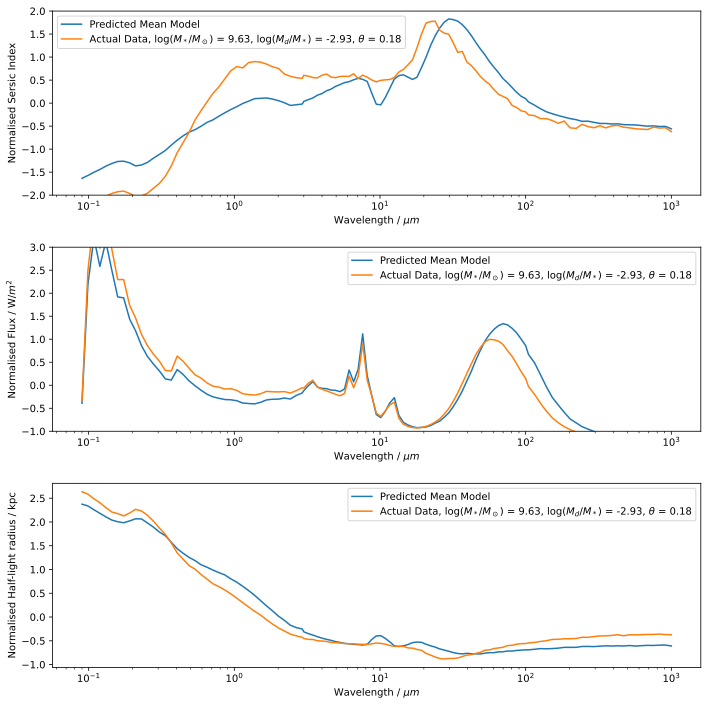

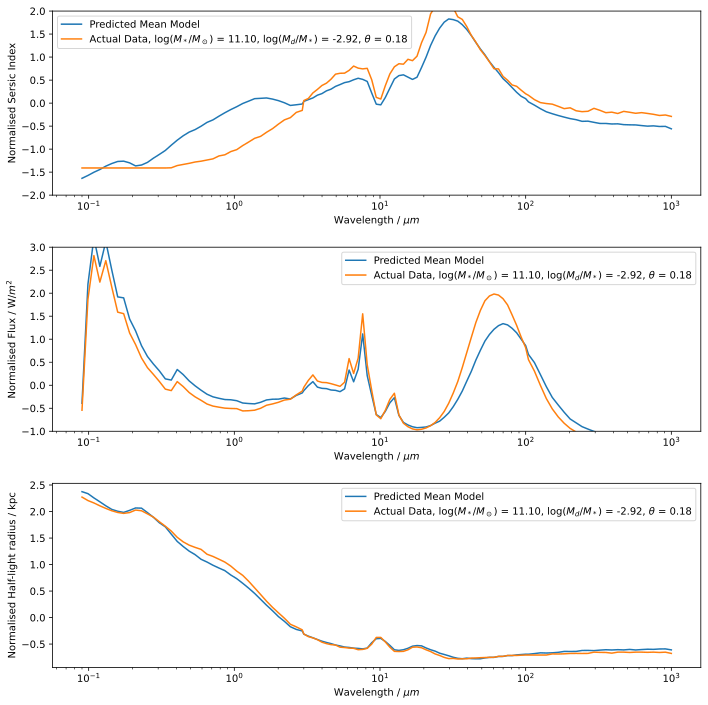

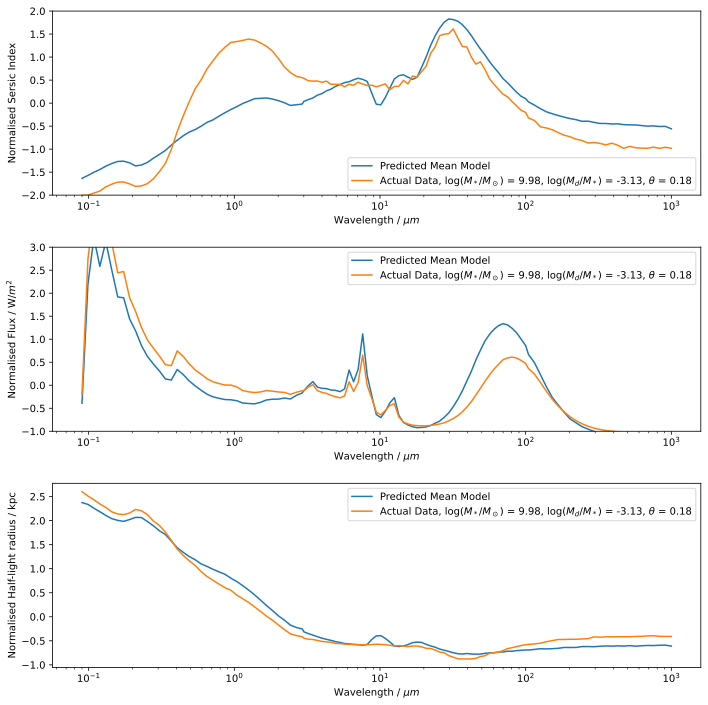

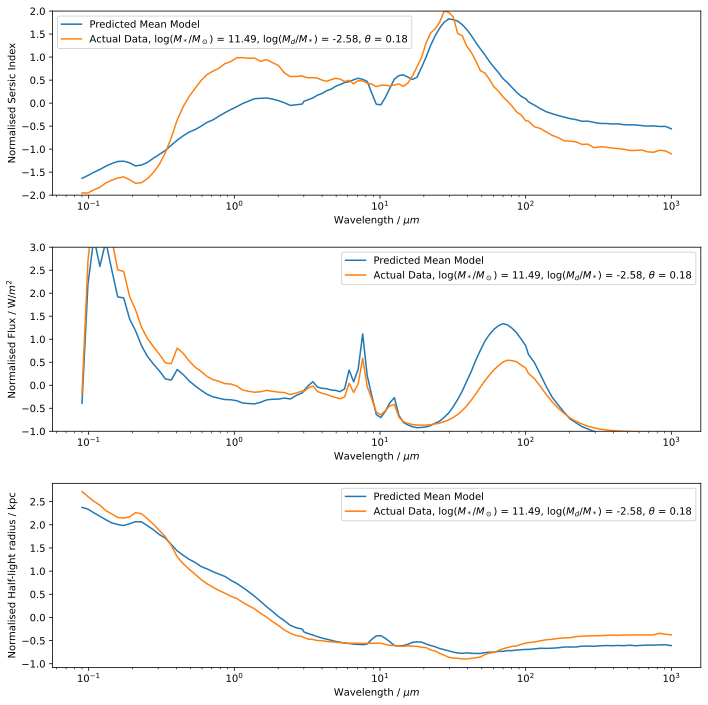

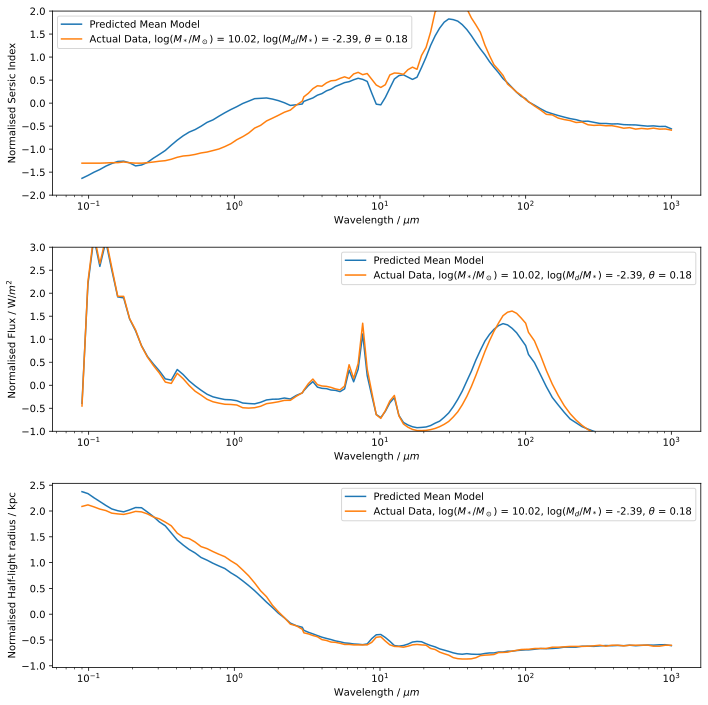

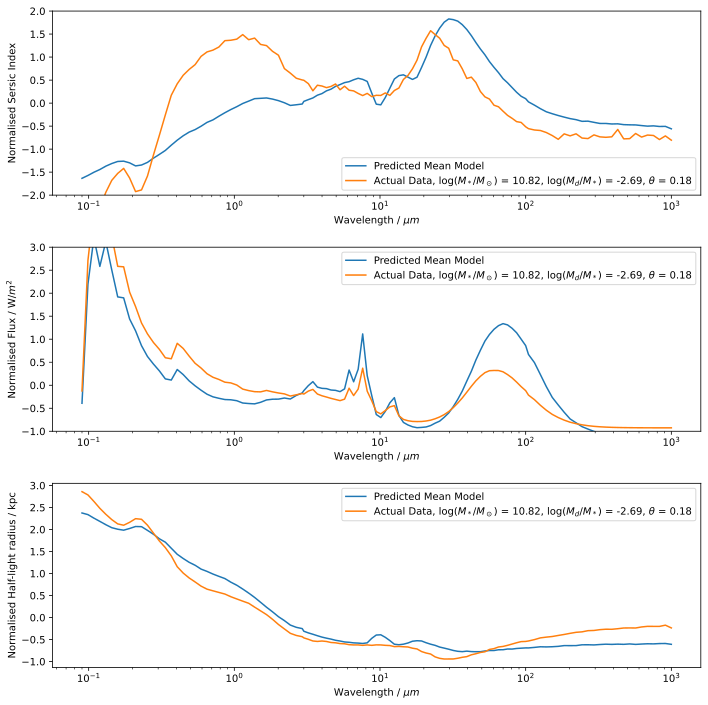

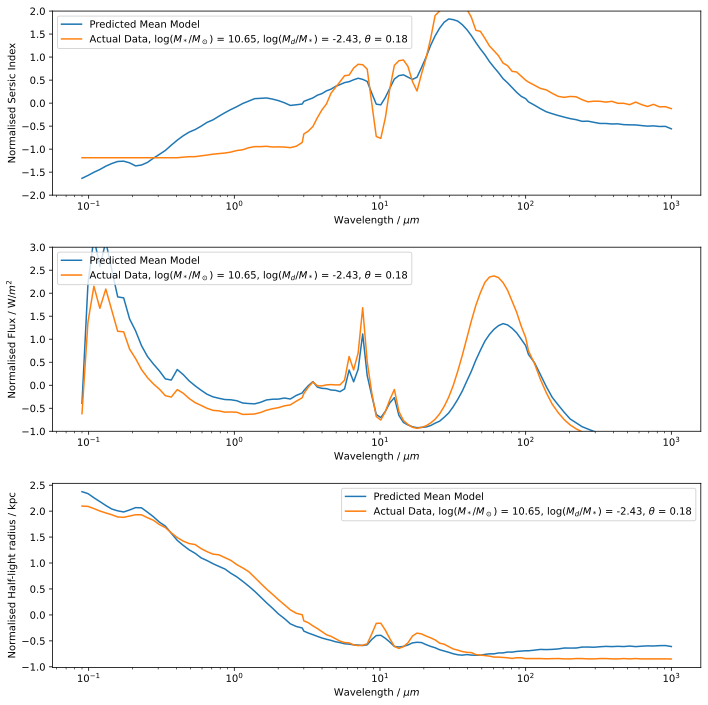

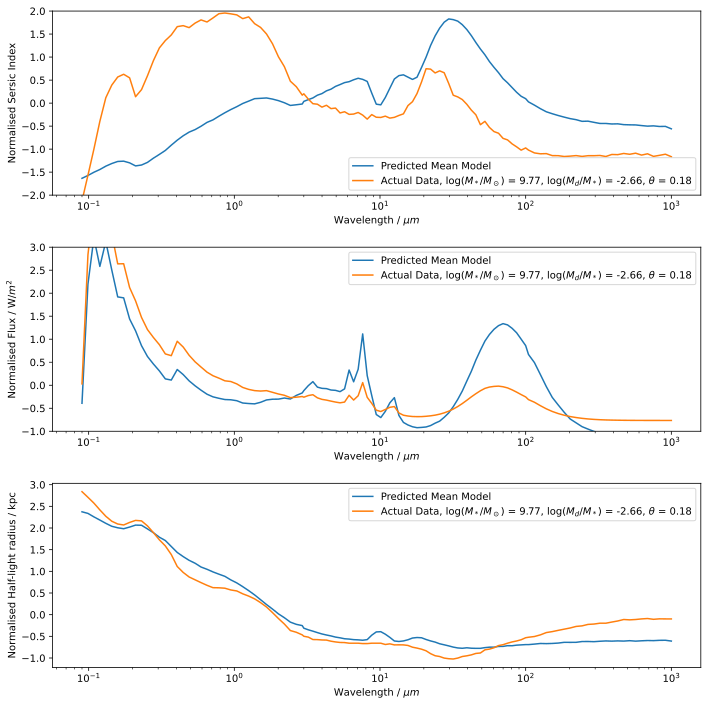

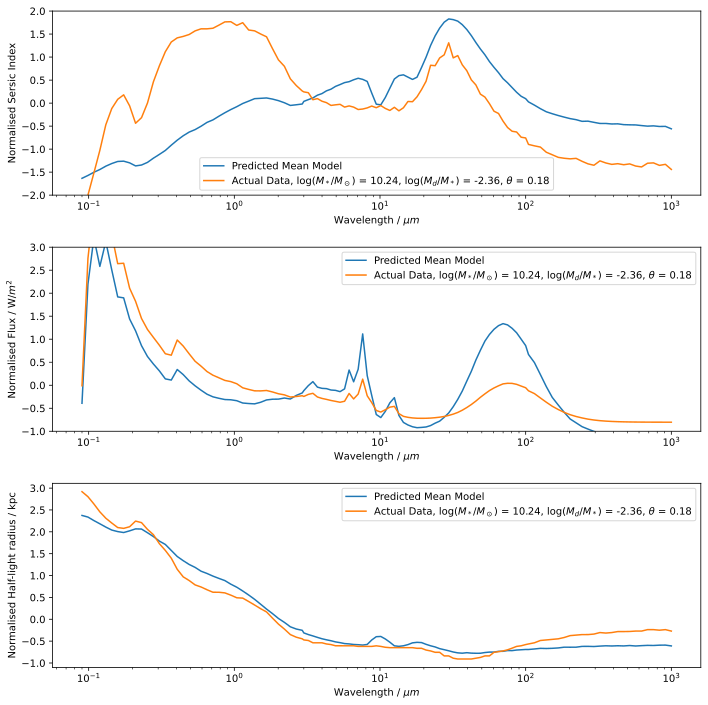

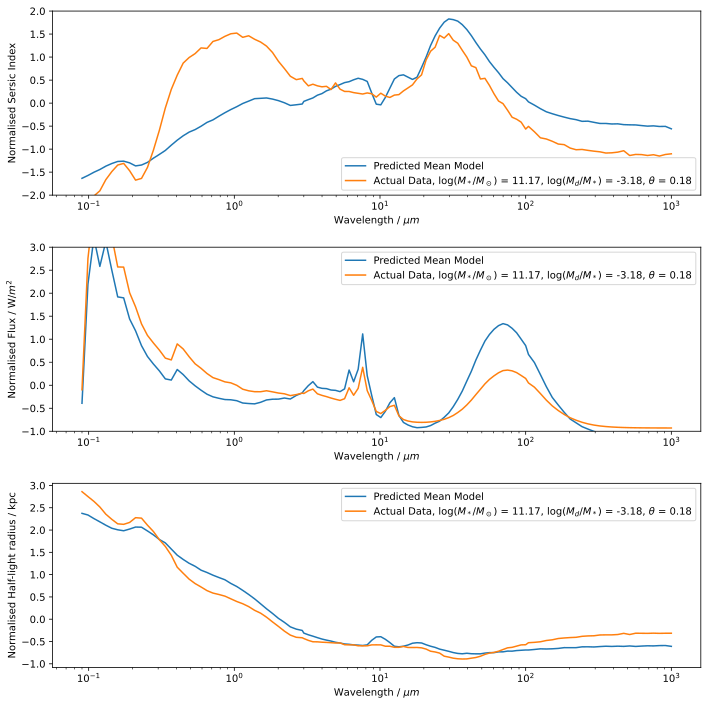

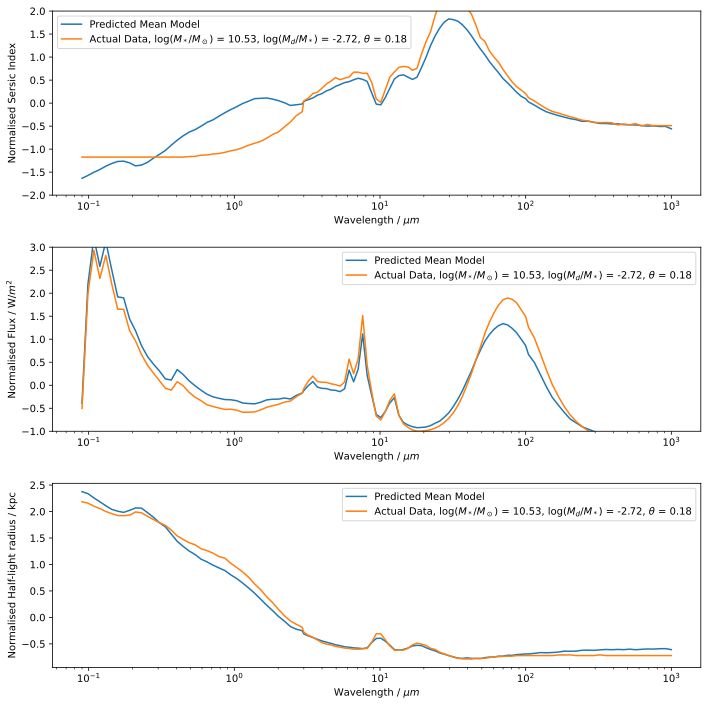

In [624]:
#plot the predicted sersic index, flux, and half-radius against wavelength on separate axes, but same figure: for all of the first galaxy's inclinations
for i in range(10, len(mean_n_results), 10):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].plot(wavelength, mean_n_results[:,i], label=f"Predicted Mean Model")
    axs[0].plot(wavelength, test_outputs[i, 0], label=f"Actual Data, $\\log(M_*/M_\\odot)$ = {test_inputs[i,0]:.2f}, $\\log(M_d/M_*)$ = {test_inputs[i,1]:.2f}, $\\theta$ = {test_inputs[i,2]:.2f}")
    axs[0].set_xlabel("Wavelength / $\\mu m$")
    axs[0].set_ylabel("Normalised Sersic Index")
    axs[0].set_xscale("log")
    axs[0].set_ylim(-2, 2)
    axs[0].legend()

    axs[1].plot(wavelength, mean_f_results[:,i], label=f"Predicted Mean Model")
    axs[1].plot(wavelength, test_outputs[i, 1], label=f"Actual Data, $\\log(M_*/M_\\odot)$ = {test_inputs[i,0]:.2f}, $\\log(M_d/M_*)$ = {test_inputs[i,1]:.2f}, $\\theta$ = {test_inputs[i,2]:.2f}")
    axs[1].set_xlabel("Wavelength / $\\mu m$")
    axs[1].set_ylabel("Normalised Flux / W/$m^2$")
    axs[1].set_xscale("log")
    axs[1].set_ylim(-1, 3)
    axs[1].legend()

    axs[2].plot(wavelength, mean_r_results[:,i], label=f"Predicted Mean Model")
    axs[2].plot(wavelength, test_outputs[i, 2], label=f"Actual Data, $\\log(M_*/M_\\odot)$ = {test_inputs[i,0]:.2f}, $\\log(M_d/M_*)$ = {test_inputs[i,1]:.2f}, $\\theta$ = {test_inputs[i,2]:.2f}")
    axs[2].set_xlabel("Wavelength / $\\mu m$")
    axs[2].set_ylabel("Normalised Half-light radius / kpc")
    axs[2].set_xscale("log")
    axs[2].legend()

    plt.tight_layout()
    plt.show()
    plt.close()